In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/skindatasetsmall/skincondition2/test/Eczema/eczema-impetiginized-9.jpg
/kaggle/input/skindatasetsmall/skincondition2/test/Eczema/eczema-leg-3.jpg
/kaggle/input/skindatasetsmall/skincondition2/test/Eczema/Dyshidrosis-31.jpg
/kaggle/input/skindatasetsmall/skincondition2/test/Eczema/iododerma-1.jpg
/kaggle/input/skindatasetsmall/skincondition2/test/Eczema/id-reaction-10.jpg
/kaggle/input/skindatasetsmall/skincondition2/test/Eczema/eczema-nummular-84.jpg
/kaggle/input/skindatasetsmall/skincondition2/test/Eczema/lichen-simplex-chronicus-146.jpg
/kaggle/input/skindatasetsmall/skincondition2/test/Eczema/eczema-impetiginized-1.jpg
/kaggle/input/skindatasetsmall/skincondition2/test/Eczema/fissure-5.jpg
/kaggle/input/skindatasetsmall/skincondition2/test/Eczema/eczema-leg-10.jpg
/kaggle/input/skindatasetsmall/skincondition2/test/Eczema/eczema-chronic-2.jpg
/kaggle/input/skindatasetsmall/skincondition2/test/Eczema/eczema-chronic-35.jpg
/kaggle/input/skindatasetsmall/skincondition2/te

In [2]:
import os
import numpy as np
import cv2
import random
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras import backend as K
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

## Load Data

In [3]:
data_path = '/kaggle/input/skindatasetsmall/skincondition2/train'
# train_path = os.path.join(data_path, 'train')
# test_path = os.path.join(data_path, 'test')

In [4]:
train_data = []
val_data = []

for folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder)
    file = os.listdir(folder_path)
    num_train = int(0.8 * len(file))
    files_train = random.sample(file, num_train)
    files_val = list(set(file) - set(files_train))
    
    for file in files_train:
        print(file)
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        train_data.append((img, folder))
        
    for file in files_val:
        print(file)
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        val_data.append((img, folder))

lichen-simplex-chronicus-189.jpg
eczema-subacute-105.jpg
eczema-subacute-5.jpg
eczema-hand-105.jpg
fissure-10.jpg
eczema-subacute-81.jpg
eczema-asteatotic-56.jpg
neurotic-excoriations-47.jpg
Dyshidrosis-22.jpg
eczema-subacute-52.jpg
eczema-subacute-94.jpg
05hyperkeratosis02010.jpg
eczema-fingertips-93.jpg
eczema-subacute-72.jpg
pompholyx-35.jpg
neurotic-excoriations-6.jpg
eczema-areola-2.jpg
eczema-leg-8.jpg
keratolysis-exfoliativa-18.jpg
eczema-hand-95.jpg
prurigo-nodularis-17.jpg
stasis-dermatitis-143.jpg
eczema-vulva-3.jpg
eczema-face-1.jpg
eczema-hand-170.jpg
lichen-simplex-chronicus-84.jpg
eczema-fingertips-33.jpg
stasis-dermatitis-117.jpg
eczema-fingertips-103.jpg
eczema-nummular-168.jpg
eczema-nummular-91.jpg
stasis-dermatitis-192.jpg
eczema-hand-161.jpg
eczema-leg-20.jpg
keratolysis-exfoliativa-7.jpg
eczema-fingertips-128.jpg
eczema-trunk-generalized-27.jpg
lichen-simplex-chronicus-130.jpg
stasis-dermatitis-166.jpg
Dyshidrosis-32.jpg
desquamation-9.jpg
eczema-foot-29.jpg
eczema

In [5]:
print(f"Total training images: {len(train_data)}")
print(f"Total validation images: {len(val_data)}")

Total training images: 1035
Total validation images: 261


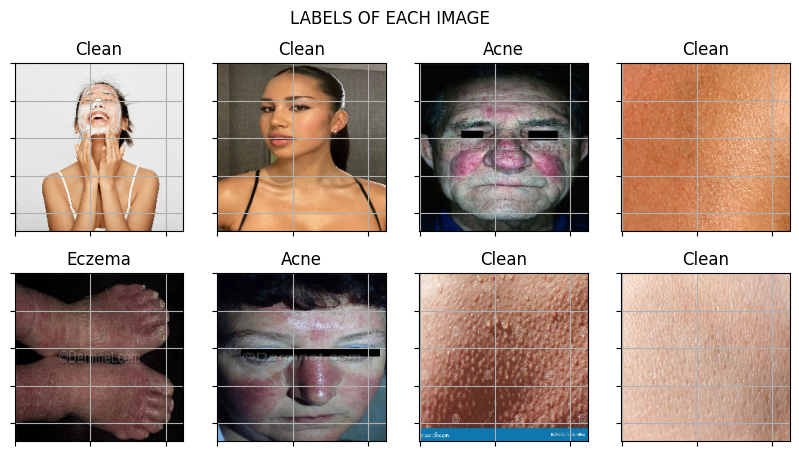

In [6]:
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
plt.suptitle('LABELS OF EACH IMAGE')

for (img, label), ax in zip(random.sample(train_data, 8), axes.flatten()):
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.grid(True)
    ax.set_title(label)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB) )

plt.show()

## Prepare Model

In [7]:
# Extract images and labels from the training and validation data
X_train, y_train = zip(*train_data)
X_val, y_val = zip(*val_data)

# Convert lists to numpy arrays for processing
X_train = np.array(X_train)
X_val = np.array(X_val)

# Encode the labels as integers
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)

# Convert the integer labels to one-hot encoded vectors
num_classes = len(le.classes_)  # Determine the number of classes based on the labels
y_train_one_hot = to_categorical(y_train_encoded, num_classes)
y_val_one_hot = to_categorical(y_val_encoded, num_classes)

# Preprocess the images for ResNet50
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)

In [8]:
# Set up early stopping
custom_early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    min_delta=0.001, 
    mode='min'
)

ResNet50 :
Epoch 1/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 111s 6s/step - accuracy: 0.4872 - loss: 2.0974 - val_accuracy: 0.7165 - val_loss: 0.5831
Epoch 2/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 100s 6s/step - accuracy: 0.7666 - loss: 0.5514 - val_accuracy: 0.7471 - val_loss: 0.5733
Epoch 3/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 142s 6s/step - accuracy: 0.8542 - loss: 0.3596 - val_accuracy: 0.7969 - val_loss: 0.5150
Epoch 4/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 101s 6s/step - accuracy: 0.8985 - loss: 0.2759 - val_accuracy: 0.7854 - val_loss: 0.5525
Epoch 5/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 142s 6s/step - accuracy: 0.9064 - loss: 0.2409 - val_accuracy: 0.7510 - val_loss: 0.5586
9/9 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step
Validation Accuracy: 0.7509578544061303
              precision    recall  f1-score   support

        Acne       0.84      0.79      0.82        67
       Clean       1.00      0.99      0.99        73
      Eczema       0.74      0.31      0.44        55
   Psoriasis       0.52      0.82      0.64        66

    accura

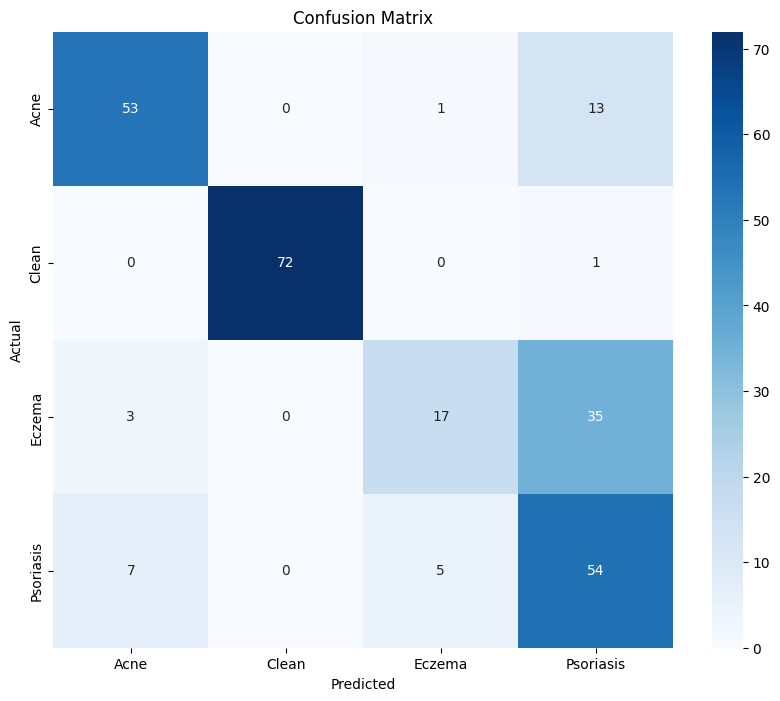

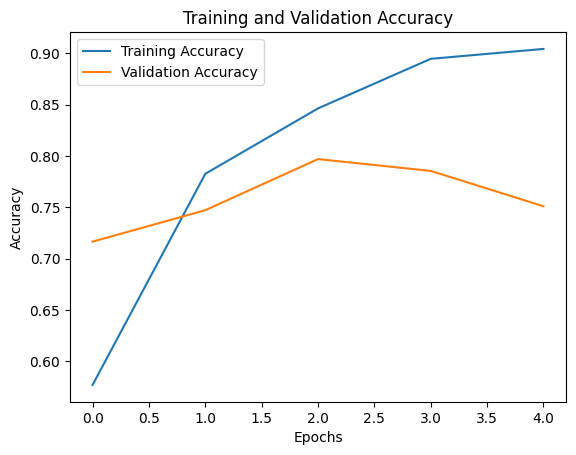

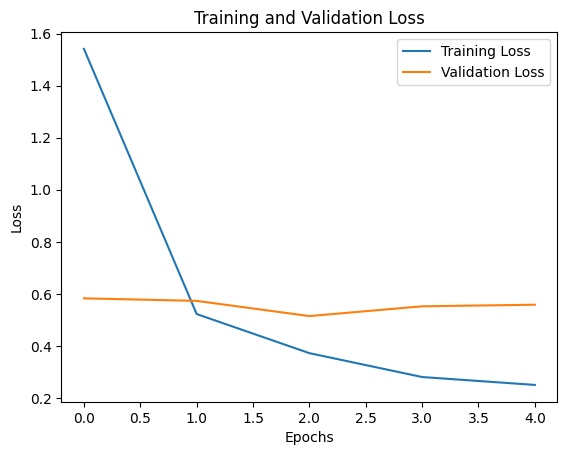

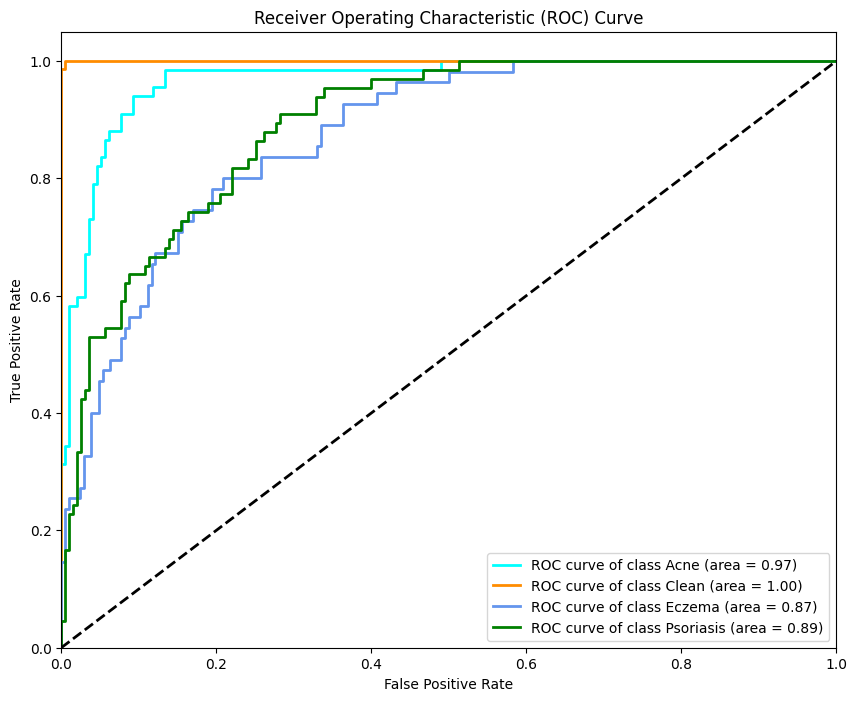

VGG16 :
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 319s 19s/step - accuracy: 0.4538 - loss: 2.5607 - val_accuracy: 0.6513 - val_loss: 0.9275
Epoch 2/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 321s 19s/step - accuracy: 0.7693 - loss: 0.6628 - val_accuracy: 0.7471 - val_loss: 0.6655
Epoch 3/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 319s 19s/step - accuracy: 0.8591 - loss: 0.3530 - val_accuracy: 0.7701 - val_loss: 0.7091
Epoch 4/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 318s 19s/step - accuracy: 0.8850 - loss: 0.2741 - val_accuracy: 0.8046 - val_loss: 0.5823
Epoch 5/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 321s 19s/step - accuracy: 0.9593 - loss: 0.1370 - val_accuracy: 0.7854 - val_loss: 0.5422
9/9 ━━━━━━━━━━━━━━━━━━━━ 64s 7s/step
Validation Accuracy: 0.7854406130268199
              precision    recall  f1-score   support

        Acne       0.82      0.81      0.81        67
       Clean       1.00      0.97      0.99        73
      Eczema       0.66      0.67      0.67        55
   Psoriasis

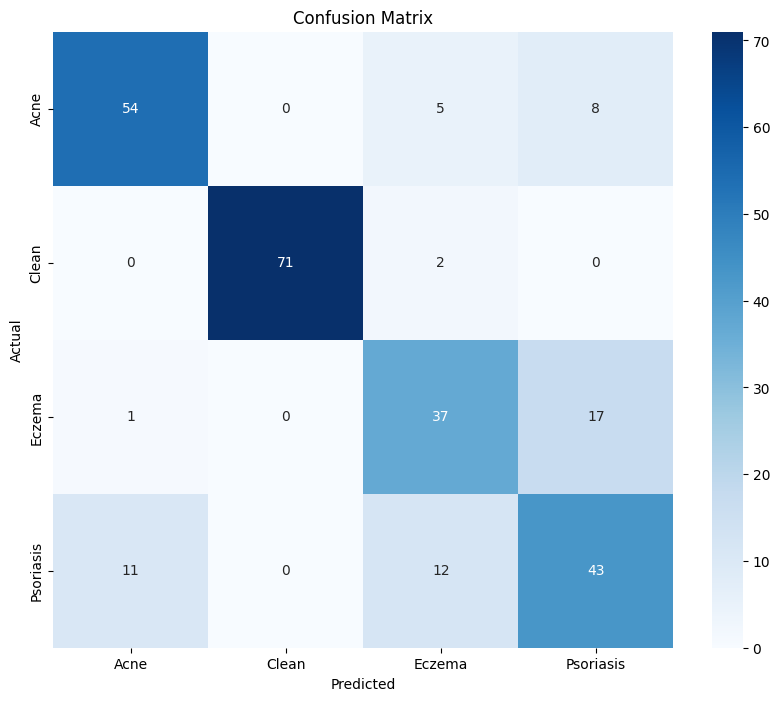

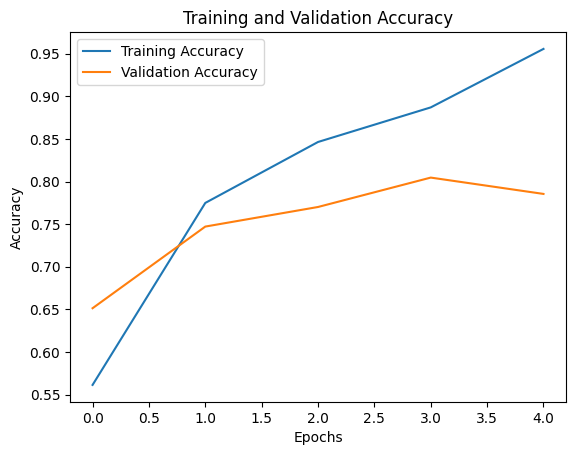

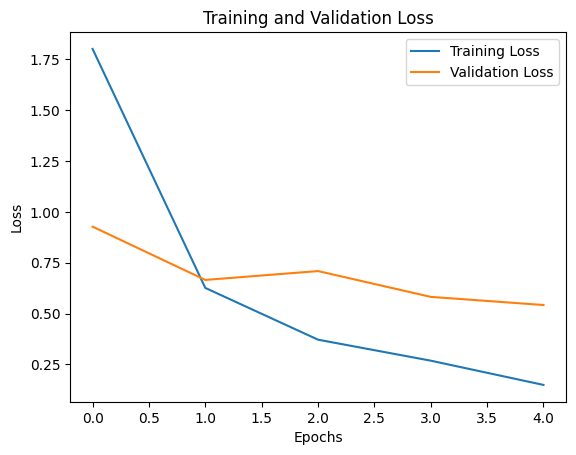

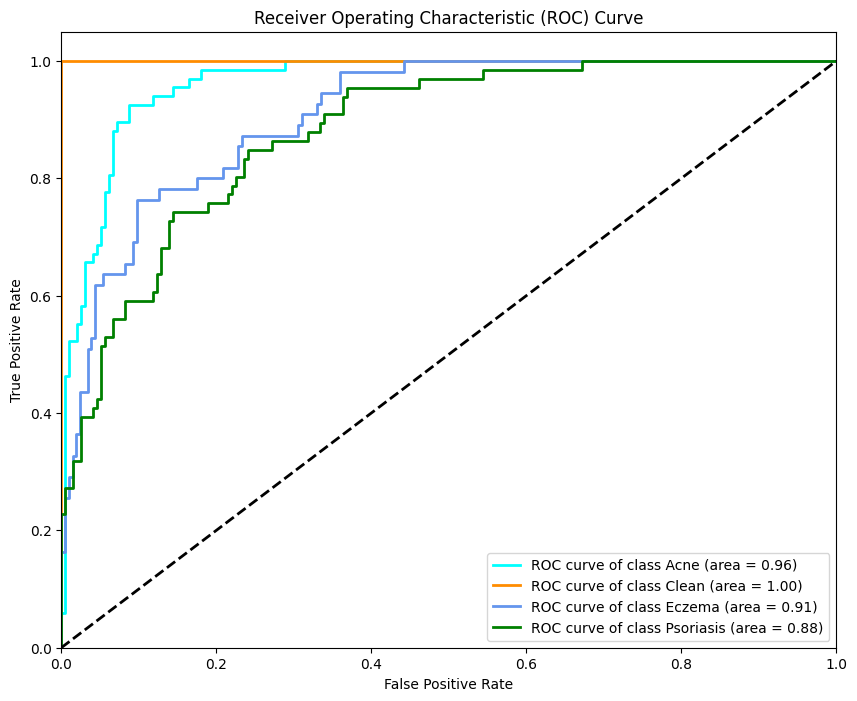

InceptionV3 :
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 77s 4s/step - accuracy: 0.2653 - loss: 42.7921 - val_accuracy: 0.3793 - val_loss: 12.0346
Epoch 2/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 65s 4s/step - accuracy: 0.3846 - loss: 7.0077 - val_accuracy: 0.4061 - val_loss: 3.3298
Epoch 3/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 65s 4s/step - accuracy: 0.4304 - loss: 3.4556 - val_accuracy: 0.4483 - val_loss: 2.2350
Epoch 4/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 65s 4s/step - accuracy: 0.5351 - loss: 1.7190 - val_accuracy: 0.4291 - val_loss: 2.2297
Epoch 5/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - accuracy: 0.5458 - loss: 1.4935 - val_accuracy: 0.4521 - val_loss: 1.9253
9/9 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step
Validation Accuracy: 0.4521072796934866
              precision    recall  f1-score   support

        Acne       0.60      0.22      0.33        67
       Clean       0.58      0.81      0.67        73
      Eczema       0.33      0.51      0.40        55
   Psoriasis  

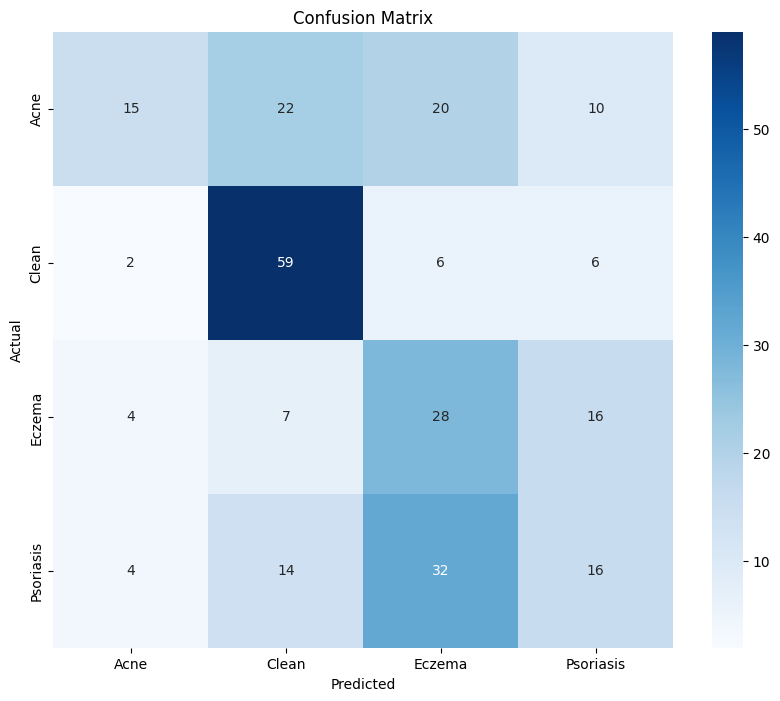

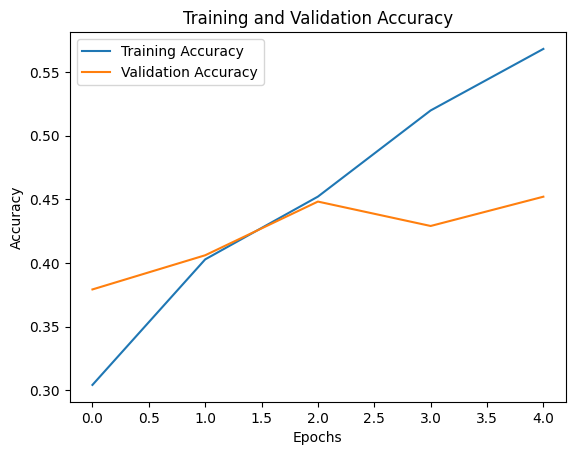

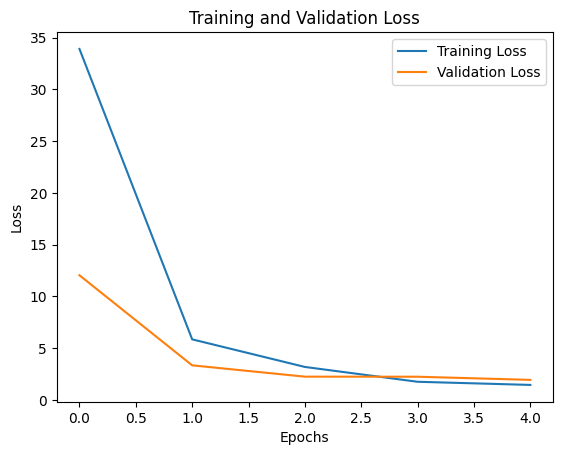

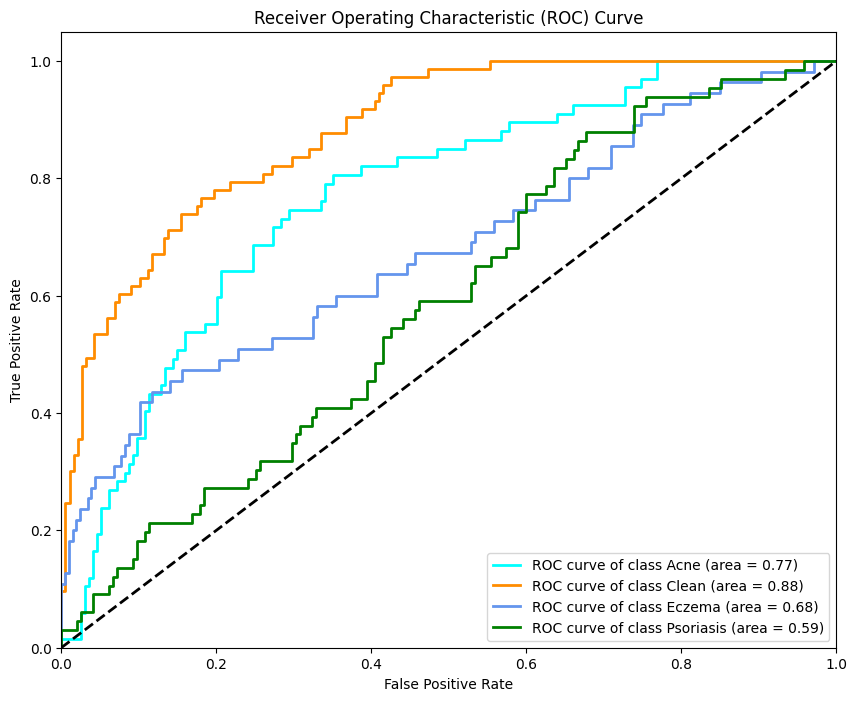

MobileNetV2 :
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.3650 - loss: 1.7452 - val_accuracy: 0.5862 - val_loss: 0.9531
Epoch 2/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.6483 - loss: 0.8230 - val_accuracy: 0.6169 - val_loss: 0.8390
Epoch 3/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.7455 - loss: 0.6237 - val_accuracy: 0.6245 - val_loss: 0.8230
Epoch 4/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.8088 - loss: 0.5151 - val_accuracy: 0.6552 - val_loss: 0.7691
Epoch 5/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.8289 - loss: 0.4528 - val_accuracy: 0.6360 - val_loss: 0.7877
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 739ms/step
Validation Accuracy: 0.6360153256704981
              precision    recall  f1-score   support

        Acne       0.67      0.61      0.64        67
       Clean       0.91      0.93      0.92        73
      Eczema       0.48      0.44      0.46        55
   Psoriasis    

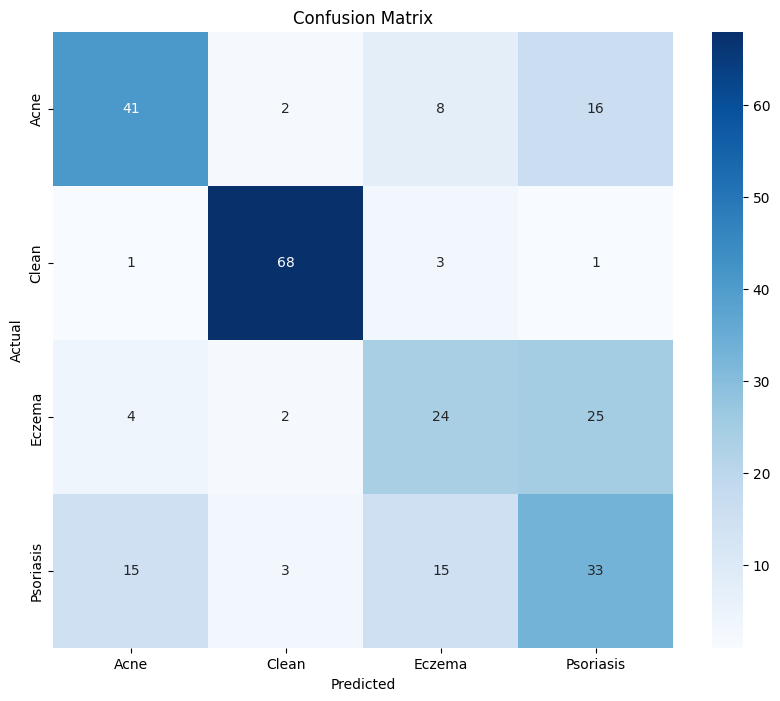

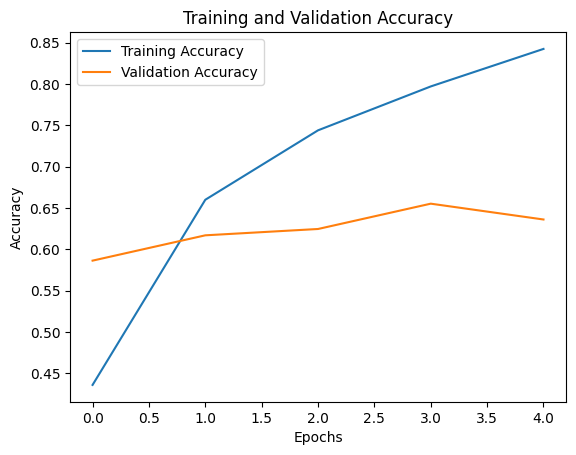

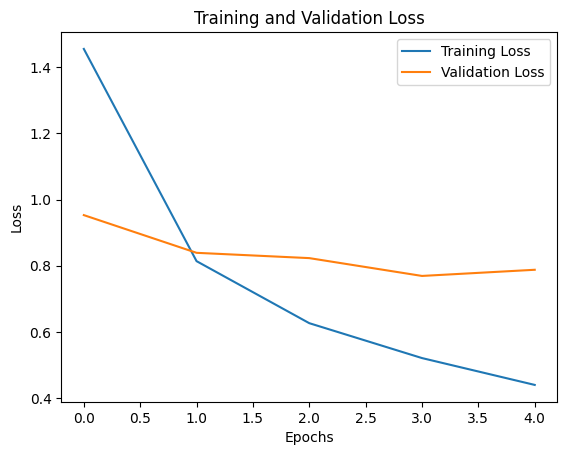

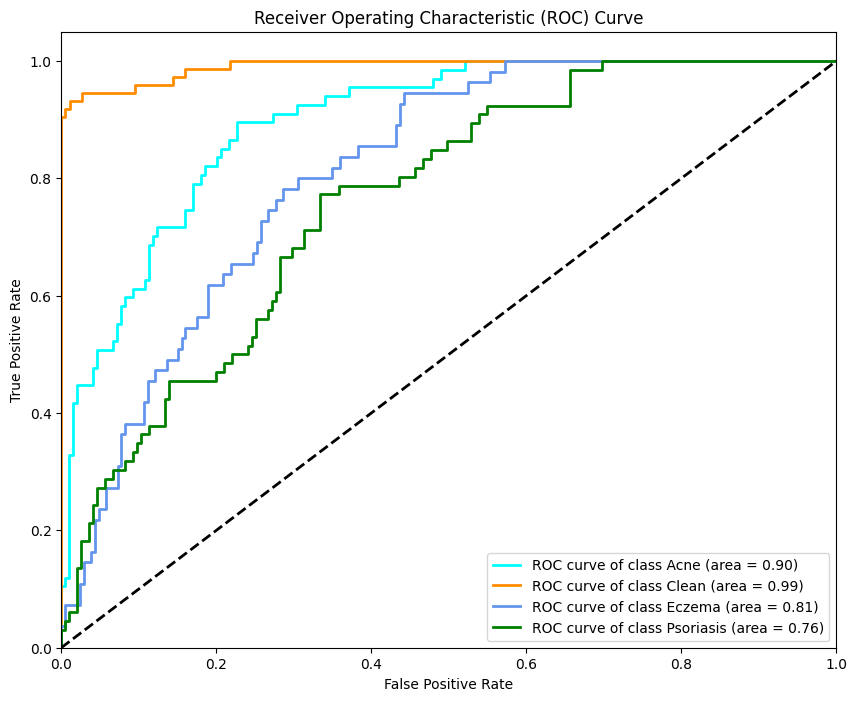

EfficientNetB0 :
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - accuracy: 0.5897 - loss: 0.9449 - val_accuracy: 0.7050 - val_loss: 0.6584
Epoch 2/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.8002 - loss: 0.4844 - val_accuracy: 0.7625 - val_loss: 0.5347
Epoch 3/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.8586 - loss: 0.3688 - val_accuracy: 0.7510 - val_loss: 0.5255
Epoch 4/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.9169 - loss: 0.2651 - val_accuracy: 0.7739 - val_loss: 0.4983
Epoch 5/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.9340 - loss: 0.2147 - val_accuracy: 0.7778 - val_loss: 0.5551
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step
Validation Accuracy: 0.7777777777777778
              precision    recall  f1-score   support

        Acne       0.78      0.85      0.81        67
       Clean       0.99      0.99      0.99        73
      Eczema       0.59      0.71      0.64        55
   Psoriasis 

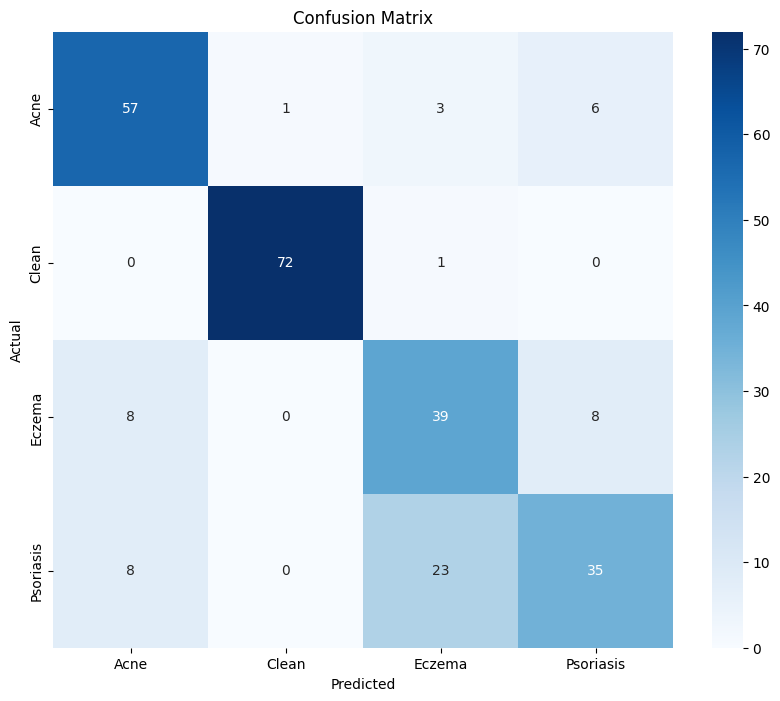

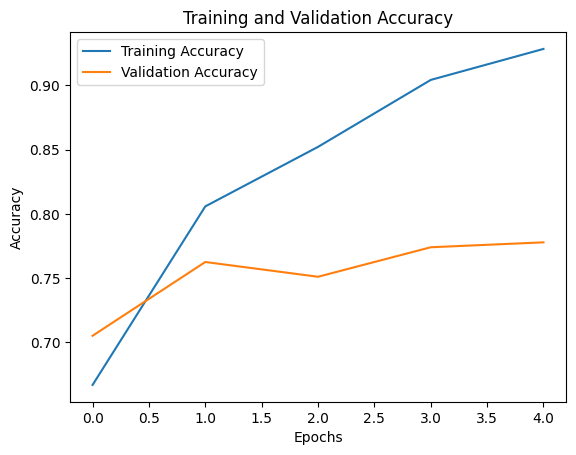

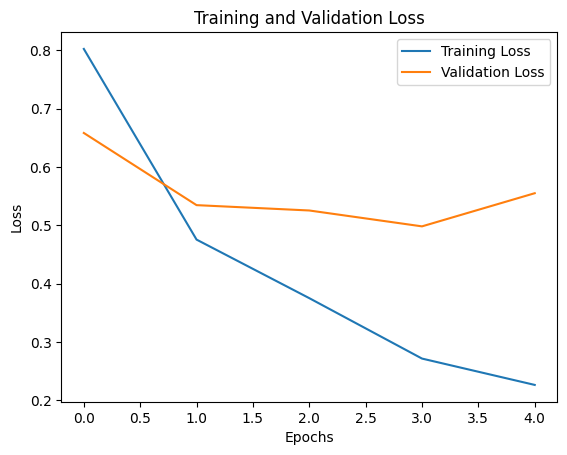

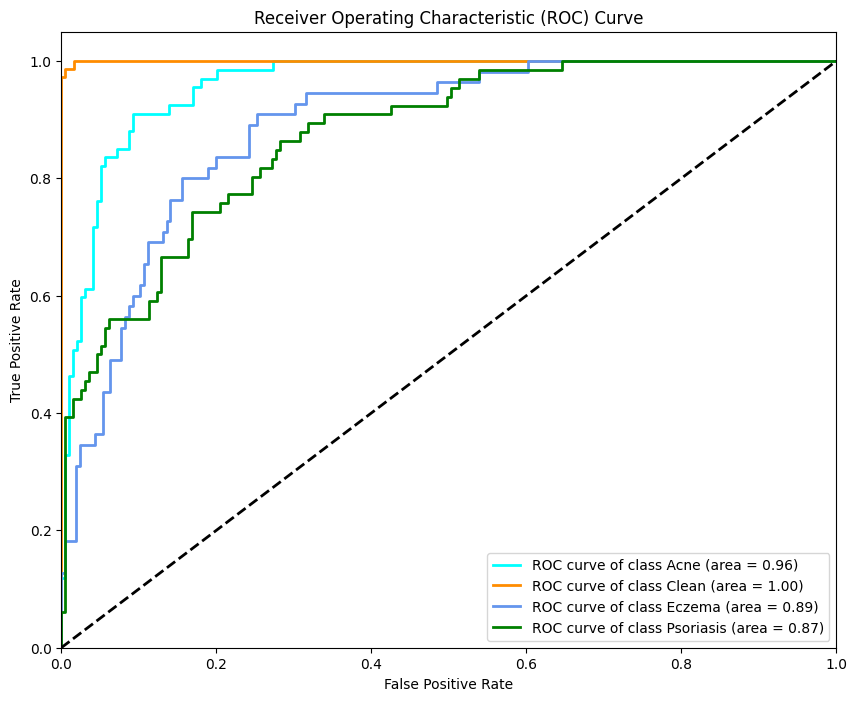

In [9]:
EPOCHS = 5  # Number of training epochs
BATCH_SIZE = 64  # Number of images per batch

# Loop through each model type
for model_type in ['ResNet50', 'VGG16', 'InceptionV3', 'MobileNetV2', 'EfficientNetB0']:
    
    print(model_type, ':')
    if model_type == 'ResNet50':
        from tensorflow.keras.applications import ResNet50
        from tensorflow.keras.applications.resnet50 import preprocess_input
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    elif model_type == 'VGG16':
        from tensorflow.keras.applications import VGG16
        from tensorflow.keras.applications.vgg16 import preprocess_input
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    elif model_type == 'InceptionV3':
        from tensorflow.keras.applications import InceptionV3
        from tensorflow.keras.applications.inception_v3 import preprocess_input
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    elif model_type == 'MobileNetV2':
        from tensorflow.keras.applications import MobileNetV2
        from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    elif model_type == 'EfficientNetB0':
        from tensorflow.keras.applications import EfficientNetB0
        from tensorflow.keras.applications.efficientnet import preprocess_input
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Set the base model to be non-trainable
    base_model.trainable = False
    
    # Add custom layers on top
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    # Compile the model
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model
    EPOCHS = 5  # Number of training epochs
    BATCH_SIZE = 64  # Number of images per batch
    history = model.fit(
        X_train, 
        y_train_one_hot, 
        validation_data=(X_val, y_val_one_hot),
        epochs=EPOCHS, 
        batch_size=BATCH_SIZE, 
        callbacks=[custom_early_stopping])
    
    # Save the model and label encoder
    model.save(f'/kaggle/working/{model_type}_model.h5')
    with open(f'/kaggle/working/{model_type}_label_encoder.pkl', 'wb') as file:
        pickle.dump(le, file)
        
    # Make predictions on the validation set
    y_val_pred = model.predict(X_val)

    # Convert predictions from one-hot encoded format to label indices
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)
    y_val_true_classes = np.argmax(y_val_one_hot, axis=1)
    

    # Calculate accuracy
    accuracy = accuracy_score(y_val_true_classes, y_val_pred_classes)
    print(f"Validation Accuracy: {accuracy}")

    
    # Generate a classification report
    report = classification_report(y_val_true_classes, y_val_pred_classes, target_names=le.classes_)
    print(report)
       

    # Generate the confusion matrix
    conf_matrix = confusion_matrix(y_val_true_classes, y_val_pred_classes)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    
    # Plot training & validation accuracy
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot training & validation loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    
    # Binarize the labels for multi-class ROC calculation
    y_val_bin = label_binarize(y_val_true_classes, classes=range(num_classes))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_val_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_val_bin.ravel(), y_val_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curve for each class
    plt.figure(figsize=(10, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])  # Add more colors if needed

    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {le.classes_[i]} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    # Clear the model from memory to save resources
    del model
    K.clear_session()